In [80]:
from pynwb import NWBHDF5IO
#from nwbwidgets import nwb2widget
import h5py, glob, os
import numpy as np
import matplotlib.pyplot as plt
from dlab import sglx_analysis as sglx
from dlab import psth_and_raster as pr
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm as tqdm
import glob
import pickle as pkl
import json
import datetime as dt
import h5py
from dlab import sglx_analysis as sglx
# import jlh_ephys as jlh
import matplotlib.pyplot as plt
# from open_ephys.analysis import Session
import seaborn as sns




In [322]:
class Eopn3_Ephys:

    def __init__(self,nwb_path):
       self.nwb_path = nwb_path
       self.load_nwb()
       self.structure = StructureData(self)
       self.plotter = Eopn3_Plotter(self, self)
     
    def nwb(self):
        if self.nwb is None:
            self.load_nwb()
        return self.nwb

    def load_nwb(self):
        nwb_path = self.nwb_path
        io = NWBHDF5IO(nwb_path, 'r')
        nwb = io.read()
        self.nwb = nwb
        return self.nwb
    
    def trials(self):
        nwb = self.nwb
        trials_df = nwb.trials.to_dataframe()
        trials_df.loc[2100:2699,'contacts'] = '10r'  #specific to this recording, fixes an error in dataframe
        self.trials_df = trials_df

        return trials_df
    
    def units(self):
        nwb = self.nwb
        units_df = nwb.units.to_dataframe()
        self.units_df = units_df
        return units_df
    


In [323]:
class StructureData(Eopn3_Ephys):


    def __init__(self,eopn3_ephys):
         self.eopn3_ephys = eopn3_ephys
         self.trials_df = self.eopn3_ephys.trials() # Get the trials data frame from eopn3_ephys

    def optogenetics_on_windows(self):
         optogenetics_on = []
         optogenetics_on_window = []
         trials_df = self.eopn3_ephys.trials()

         for index, value in trials_df.iterrows():
             if value["optogenetics_LED_state"] == 1:
                  optogenetics_on.append(index)
                  start_opto = value['start_time']
                  stop_opto = value['stop_time']
                  optogenetics_on_window.append([start_opto,stop_opto])
         self.optogenetics_on = optogenetics_on 
         self.optogenetics_on_window = optogenetics_on_window
         return optogenetics_on_window
     
              
    def optogenetics_off_windows(self):
          optogenetics_off = []
          optogenetics_off_window = []
          trials_df = self.eopn3_ephys.trials()

          for index, value in trials_df.iterrows():
               if value["optogenetics_LED_state"] == 0:
                    optogenetics_off.append(index)
                    start_opto = value['start_time']
                    stop_opto = value['stop_time']
                    optogenetics_off_window.append([start_opto,stop_opto])

          self.optogenetics_off = optogenetics_off
          self.optogenetics_off_window = optogenetics_off_window

          return optogenetics_off_window
               
                  
                  
              


In [324]:
class SpikeTimes(Eopn3_Ephys):

    def __init__(self,eopn3_ephys):
        self.eopn3_ephys = eopn3_ephys
        # self.structure_data = structure_data

    def find_spike(self):
        units_df = self.eopn3_ephys.units()
        # for index, value in self.units_df.iterrows():
        
        print(units_df['spike_times'])

In [334]:

class Eopn3_Plotter(Eopn3_Ephys):
      
    def __init__(self, eopn3_ephys, structure_data):
        self.eopn3_ephys = eopn3_ephys
        self.structure_data = structure_data


    def all_psth(self):
        plt.figure(figsize=(10, 6))
        self.units_df = self.eopn3_ephys.units()

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in self.units_df.iterrows():
        
            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']

            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        # After plotting all neurons' spikes, display the plot
        plt.show()

    def all_psth_opto_on(self):
        plt.figure(figsize=(10, 6))
        self.units_df = self.eopn3_ephys.units()

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in self.units_df.iterrows():
        
            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']

            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        # After plotting all neurons' spikes, display the plot
        plt.show()

    def optogenetic_on_psth(self,otpo_window_number):

        optogenetics_on_windows = self.structure_data.optogenetics_on_windows()
        units_df = self.eopn3_ephys.units()
        plt.figure(figsize=(10, 6))

            # Iterate over each row (neuron) in the DataFrame
        print(optogenetics_on_windows[otpo_window_number][0],optogenetics_on_windows[otpo_window_number][1])

        for index, row in units_df.iterrows():
            # If this neuron is not in the list of selected neurons, skip it

            spike_times = [time for time in row['spike_times'] if optogenetics_on_windows[otpo_window_number][0] <= time <= optogenetics_on_windows[otpo_window_number][1]]
            neuron_numbers = [index] * len(spike_times)

            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        #         i += 1
        plt.show()
        return('Optogentic on')

    def optogenetic_off_psth(self,otpo_off_number):

        optogenetics_off_windows = self.structure_data.optogenetics_off_windows()
        units_df = self.eopn3_ephys.units()
        plt.figure(figsize=(10, 6))
        print(optogenetics_off_windows[otpo_off_number][0],optogenetics_off_windows[otpo_off_number][1])
            # Iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # If this neuron is not in the list of selected neurons, skip it
           
            spike_times = [time for time in row['spike_times'] if optogenetics_off_windows[otpo_off_number][0] <= time <= optogenetics_off_windows[otpo_off_number][1]]
            neuron_numbers = [index] * len(spike_times)

            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        #         i += 1
        plt.show()
        return('Optogentic off')


    # def optogenetic_off_psth(self):
    #     optogenetics_off = self.structure_data.optogenetics_off_windows()
    #     units_df = self.eopn3_ephys.units()

    #     plt.figure(figsize=(10, 6))
    #     i = 0
    #     for index, row in units_df.iterrows():
    #         if index == optogenetics_off[i]:
    #             spike_times = row['spike_times']
    #             neuron_numbers = [index] * len(spike_times)
    #             plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
    #             i += 1
    #     plt.show()



In [335]:
nwb_path = "/Users/grant/Documents/coding/neural_data/eOPN3_46.nwb"

eopn3 = Eopn3_Ephys(nwb_path)
structure_data = StructureData(eopn3)
plotter = Eopn3_Plotter(eopn3, structure_data)
spikes = SpikeTimes(eopn3)



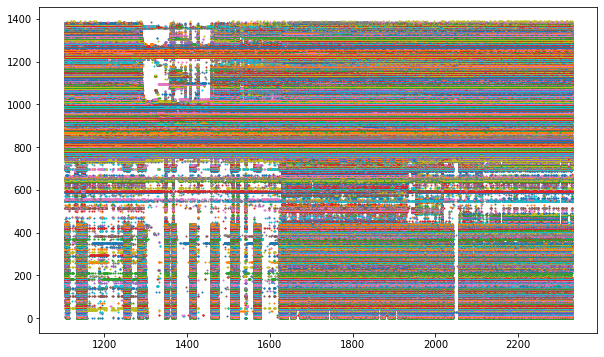

In [341]:
plotter.all_psth()

1651.1004666666668 1654.1052646464648


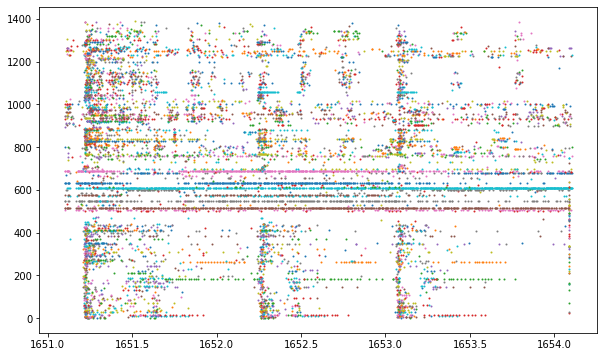

'Optogentic off'

In [338]:
plotter.optogenetic_off_psth(5)

1675.1222242758968 1678.1270222556948


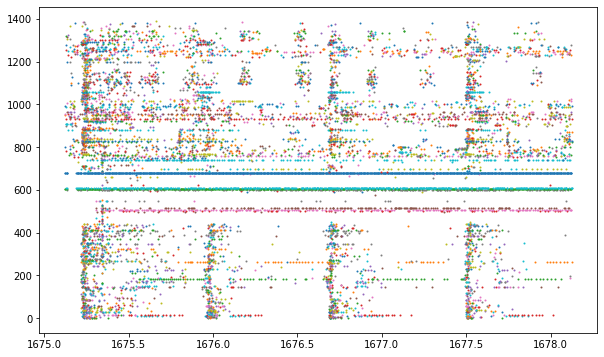

'Optogentic on'

In [340]:
plotter.optogenetic_on_psth(6)

In [330]:
on_windows = structure_data.optogenetics_on_windows()
on_windows

[[1636.0863, 1639.091097979798],
 [1645.0951737692171, 1648.0999717490151],
 [1654.1024, 1657.107197979798],
 [1657.1059333333333, 1660.1107313131313],
 [1660.1087666666667, 1663.1135646464647],
 [1672.1202, 1675.124997979798],
 [1675.1222242758968, 1678.1270222556948],
 [1681.128, 1684.132797979798],
 [1684.1310666666666, 1687.1358646464646],
 [1690.1383666666666, 1693.1431646464646],
 [1693.1401666666666, 1696.1449646464646],
 [1696.1429666666668, 1699.1477646464648],
 [1705.1514, 1708.156197979798],
 [1708.154711207989, 1711.159509187787],
 [1711.1567666666667, 1714.1615646464647],
 [1717.1626333333334, 1720.1674313131314],
 [1720.1654666666666, 1723.1702646464646],
 [1723.1686333333334, 1726.1734313131315],
 [1726.1709333333333, 1729.1757313131313],
 [1729.1743333333334, 1732.1791313131314],
 [1741.3184666666666, 1744.3232646464646],
 [1744.3210333333334, 1747.3258313131314],
 [1747.3236333333334, 1750.3284313131314],
 [1759.4017, 1762.406497979798],
 [1771.4137, 1774.418497979798]

In [295]:
off_windows = structure_data.optogenetics_off_windows()
off_windows

[[1630.0866, 1633.091397979798],
 [1633.0826, 1636.087397979798],
 [1639.0886333333333, 1642.0934313131313],
 [1642.0915264263328, 1645.0963244061309],
 [1648.0974666666666, 1651.1022646464646],
 [1651.1004666666668, 1654.1052646464648],
 [1663.1107666666667, 1666.1155646464647],
 [1666.1146333333334, 1669.1194313131314],
 [1669.1172, 1672.121997979798],
 [1678.1251666666667, 1681.1299646464647],
 [1687.1343, 1690.139097979798],
 [1699.1457666666668, 1702.1505646464648],
 [1702.1485333333333, 1705.1533313131313],
 [1714.1594666666667, 1717.1642646464647],
 [1732.1759666666667, 1735.1807646464647],
 [1735.1794333333332, 1738.1842313131312],
 [1738.2989, 1741.303697979798],
 [1750.3271333333332, 1753.3319313131312],
 [1753.3292666666666, 1756.3340646464646],
 [1756.3989666666666, 1759.4037646464647],
 [1762.4044666666666, 1765.4092646464646],
 [1765.4077333333332, 1768.4125313131312],
 [1768.4106666666667, 1771.4154646464647],
 [1774.4160333333334, 1777.4208313131314],
 [1777.41936666666

In [229]:
eopn3.trials_df

,start_time,stop_time,stimulus,optogenetics_LED_state,flash_luminance,contacts
id,,,,,,
0,1630.086600,1633.091398,luminance_flash,0,0,NaN
1,1633.082600,1636.087398,luminance_flash,0,1,NaN
2,1636.086300,1639.091098,luminance_flash,1,0,NaN
3,1639.088633,1642.093431,luminance_flash,0,1,NaN
4,1642.091526,1645.096324,luminance_flash,0,0,NaN
...,...,...,...,...,...,...
95,1915.549567,1918.554365,luminance_flash,0,1,NaN
96,1918.552900,1921.557698,luminance_flash,1,0,NaN
97,1921.555633,1924.560431,luminance_flash,1,1,NaN


In [228]:
structure_data.optogenetics_on_time_windows()

[2,
 5,
 8,
 9,
 10,
 14,
 15,
 17,
 18,
 20,
 21,
 22,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 37,
 38,
 39,
 43,
 47,
 52,
 53,
 54,
 55,
 58,
 61,
 62,
 64,
 68,
 69,
 70,
 72,
 74,
 78,
 80,
 82,
 83,
 86,
 87,
 90,
 92,
 96,
 97,
 98,
 99]

In [227]:
spikes.find_spike()

id
0       [1109.4048936263537, 1109.818320648671, 1110.2...
1       [1108.9367264189364, 1108.938428117146, 1110.3...
2       [1107.0035413375556, 1107.0217915700377, 1107....
3       [1104.5537168053509, 1106.3120356802092, 1107....
4       [1107.0476822106343, 1108.0015932361373, 1108....
                              ...                        
1384    [1134.154436008208, 1508.7308162236252, 1522.1...
1385    [1116.516382634238, 1119.405341263333, 1121.69...
1386    [1142.7195634904638, 1166.3699626412435, 1170....
1387    [1500.2487254244165, 1523.0381296577118, 1523....
1388    [1108.526788303513, 1119.4001352960352, 1120.3...
Name: spike_times, Length: 1389, dtype: object


In [202]:
eopn3.units_df

,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times,electrodes,waveform_mean
id,,,,,,,,,,,
0,1013.195409,30.683947,3795.195409,0,1,1016.1,100.2,A,"[1109.4048936263537, 1109.818320648671, 1110.2...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,938.338041,31.053864,3720.338041,0,1,883.9,80.4,A,"[1108.9367264189364, 1108.938428117146, 1110.3...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,983.547308,27.801565,3765.547308,0,1,513.9,43.3,A,"[1107.0035413375556, 1107.0217915700377, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,925.189943,29.911659,3707.189943,0,1,922.2,244.3,A,"[1104.5537168053509, 1106.3120356802092, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,973.527915,33.743584,3755.527915,2,2,1129.2,7.4,A,"[1107.0476822106343, 1108.0015932361373, 1108....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
1384,-2333.371572,26.729427,471.628428,0,1,684.9,0.0,C,"[1134.154436008208, 1508.7308162236252, 1522.1...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1385,-1154.576101,45.339119,1650.423899,1,2,831.3,100.0,C,"[1116.516382634238, 1119.405341263333, 1121.69...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1386,-1984.479906,15.740321,820.520094,0,1,1249.9,0.0,C,"[1142.7195634904638, 1166.3699626412435, 1170....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [201]:
eopn3.trials_df

,start_time,stop_time,stimulus,optogenetics_LED_state,flash_luminance,contacts
id,,,,,,
0,1630.086600,1633.091398,luminance_flash,0,0,NaN
1,1633.082600,1636.087398,luminance_flash,0,1,NaN
2,1636.086300,1639.091098,luminance_flash,1,0,NaN
3,1639.088633,1642.093431,luminance_flash,0,1,NaN
4,1642.091526,1645.096324,luminance_flash,0,0,NaN
...,...,...,...,...,...,...
95,1915.549567,1918.554365,luminance_flash,0,1,NaN
96,1918.552900,1921.557698,luminance_flash,1,0,NaN
97,1921.555633,1924.560431,luminance_flash,1,1,NaN


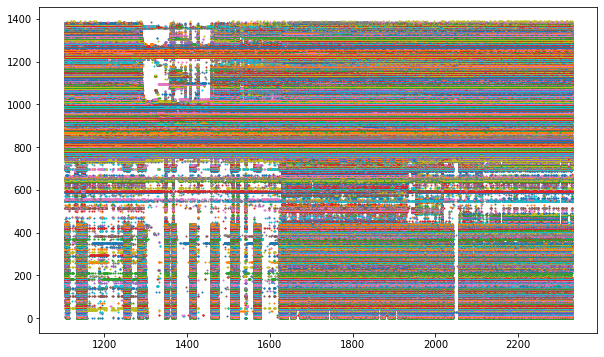

In [195]:
plotter.all_psth()

In [199]:
print(len(structure_data.optogenetics_off_windows()))
print(len(structure_data.optogenetics_time_windows()))

50
50


IndexError: list index out of range

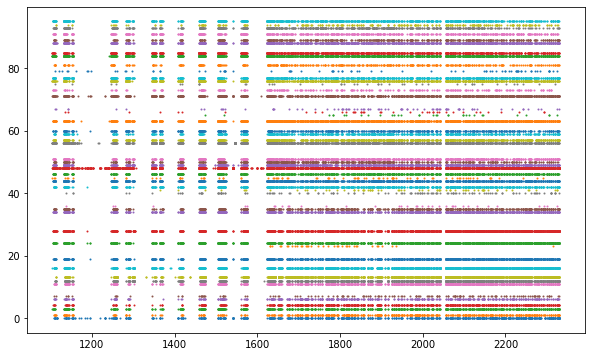

In [196]:
plotter.optogenetic_off_psth()


IndexError: list index out of range

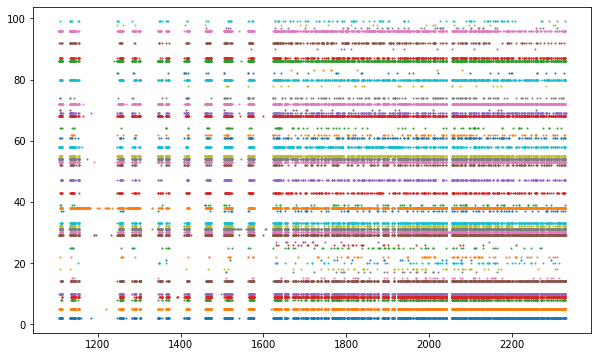

In [149]:
plotter.optogenetic_on_psth()

In [55]:
structure_data.optogenetics_time_windows()

[2,
 5,
 8,
 9,
 10,
 14,
 15,
 17,
 18,
 20,
 21,
 22,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 37,
 38,
 39,
 43,
 47,
 52,
 53,
 54,
 55,
 58,
 61,
 62,
 64,
 68,
 69,
 70,
 72,
 74,
 78,
 80,
 82,
 83,
 86,
 87,
 90,
 92,
 96,
 97,
 98,
 99]

AttributeError: 'Eopn3_Ephys' object has no attribute 'trials_df'

In [40]:
eopn3.structure.optogenetics_time_windows()

[2,
 5,
 8,
 9,
 10,
 14,
 15,
 17,
 18,
 20,
 21,
 22,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 37,
 38,
 39,
 43,
 47,
 52,
 53,
 54,
 55,
 58,
 61,
 62,
 64,
 68,
 69,
 70,
 72,
 74,
 78,
 80,
 82,
 83,
 86,
 87,
 90,
 92,
 96,
 97,
 98,
 99]

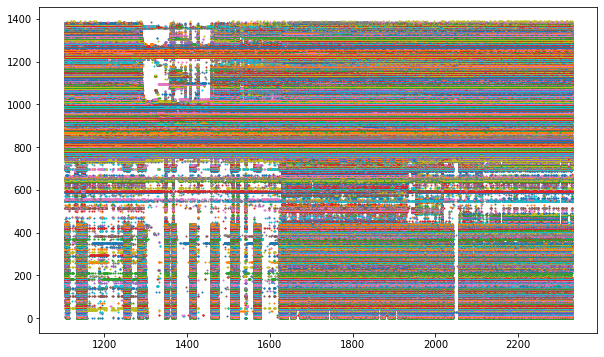

In [9]:
eopn3.plotter.all_psth()

In [84]:
eopn3.units()

,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times,electrodes,waveform_mean
id,,,,,,,,,,,
0,1013.195409,30.683947,3795.195409,0,1,1016.1,100.2,A,"[1109.4048936263537, 1109.818320648671, 1110.2...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,938.338041,31.053864,3720.338041,0,1,883.9,80.4,A,"[1108.9367264189364, 1108.938428117146, 1110.3...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,983.547308,27.801565,3765.547308,0,1,513.9,43.3,A,"[1107.0035413375556, 1107.0217915700377, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,925.189943,29.911659,3707.189943,0,1,922.2,244.3,A,"[1104.5537168053509, 1106.3120356802092, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,973.527915,33.743584,3755.527915,2,2,1129.2,7.4,A,"[1107.0476822106343, 1108.0015932361373, 1108....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
1384,-2333.371572,26.729427,471.628428,0,1,684.9,0.0,C,"[1134.154436008208, 1508.7308162236252, 1522.1...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1385,-1154.576101,45.339119,1650.423899,1,2,831.3,100.0,C,"[1116.516382634238, 1119.405341263333, 1121.69...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1386,-1984.479906,15.740321,820.520094,0,1,1249.9,0.0,C,"[1142.7195634904638, 1166.3699626412435, 1170....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


[1109.40489363 1109.81832065 1110.2971998  ... 2330.41289321 2330.41452655
 2330.41629321]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

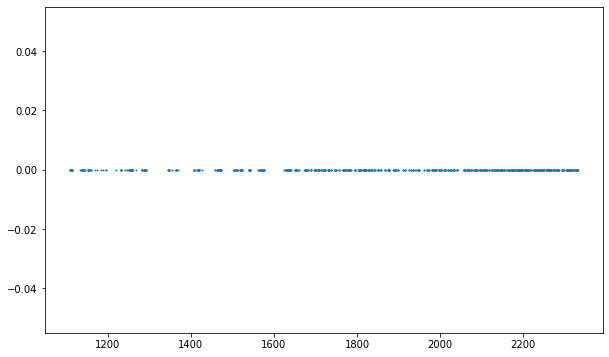

In [70]:
eopn3.all_psth()

In [61]:
# eopn3.trials()

In [42]:
# eopn3.units()

In [46]:
# eopn3.firing_frequency_distribution()

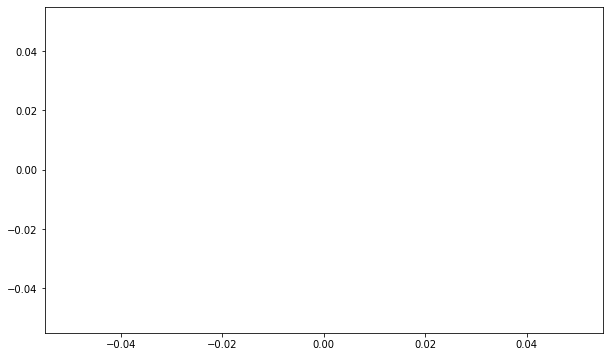

In [50]:
eopn3.multi_neuron_time_psth([],[1600,1610])

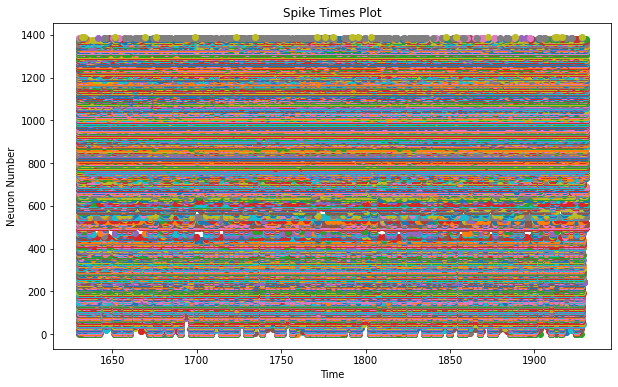

In [47]:
eopn3.plot_run_window(4)

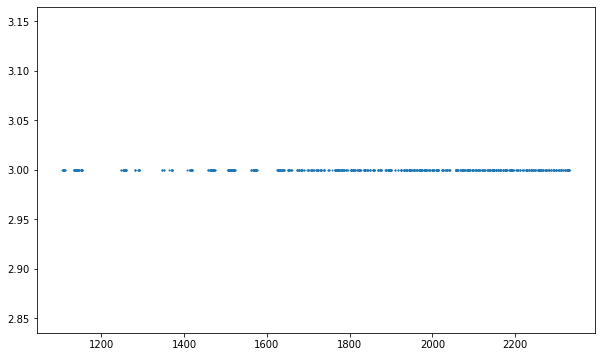

In [16]:
eopn3.single_neuron_psth(3)

In [17]:
eopn3.all_psth()

AttributeError: 'DataFrame' object has no attribute 'run'